# Feature Engineering/Selection and Training Models

## Feature Engineering/Selection: KOI Data

### Import KOI Data

In [1]:
import pandas as pd
import numpy as np

KOI_df = pd.read_csv('KOI_cumulative_cleaned.csv')

### Preparing Categorical Features and Preliminary Feature Reduction

In [2]:
# Convert object types to category
object_cols = KOI_df.select_dtypes(exclude='number').columns.to_list()
KOI_df[object_cols] = KOI_df[object_cols].astype('category')

In [3]:
# Show uniqueness of categorical features
KOI_df.select_dtypes(exclude='number').nunique()

kepoi_name           3164
koi_disposition         3
koi_pdisposition        2
koi_fittype             4
koi_parm_prov           3
koi_tce_delivname       3
koi_quarters           96
koi_sparprov            4
dtype: int64

"kepoi_name" is entirely unique and will not be informative so it will be kept for identification purposes but dropped as a feature when training. "kepid" has a slightly lower cardinality but is also identifier and the same treatment will follow. "koi_quarters" is in a binary string format that could be better represented as 32 features, each representing a quarter. Another way to transform "koi_quarters" would be to make a new feature that represents the number of quarters that transit was measured across.

In [4]:
# Turn koi_quarters into 32 features, each representing a quarter
num_quarters = 0
for binary_str in KOI_df['koi_quarters'].values:
    if len(binary_str) > num_quarters:
        num_quarters = len(binary_str)

for i in range(num_quarters):
    KOI_df[f'koi_quarters_{i+1}'] = [0 for _ in range(KOI_df.shape[0])]

for binary_str in KOI_df['koi_quarters'].values:
    for i in range(len(binary_str)):
        KOI_df[f'koi_quarters_{i+1}'] = int(binary_str[i])

In [5]:
# Make a new feature from koi_quarters that represents the number of quarters
KOI_df['num_quarters'] = [0 for _ in range(KOI_df.shape[0])]

for i, binary_str in KOI_df['koi_quarters'].items():
    num_quarters_searched = sum([int(digit) for digit in binary_str])
    KOI_df.loc[i, 'num_quarters'] = num_quarters_searched

In [6]:
# Drop koi_quarters
KOI_df = KOI_df.drop(columns='koi_quarters')

"koi_pdisposition" should be dropped since it is the guess from NASA's own automated system (based on rules but not a machine learning model). It will likely be a very strong predictor of "koi_disposition" but is not ideal for this project since part of the interest is to see how the models can compare to NASA's predictions. The same can be said for "koi_score" and false positive flags since they come from Robovetter (NASA's rule-based classifier). Their inclusion will be reconsidered depending on model performance.

In [7]:
# Drop koi_pdisposition and koi_score
KOI_df = KOI_df.drop(columns=['koi_pdisposition', 'koi_score'])

# Drop false positive flags
cols = KOI_df.columns
for col in cols:
    if col.find('fpflag') != -1:
        print(f'Flag will be dropped: {col}')
        KOI_df = KOI_df.drop(columns=col)

Flag will be dropped: koi_fpflag_nt
Flag will be dropped: koi_fpflag_ss
Flag will be dropped: koi_fpflag_co
Flag will be dropped: koi_fpflag_ec


Features related to errors will be dropped because they typically have high collinearity, include noise, and are not very interpretable. They could give insights into the distribution of the variable they correspond to, but there is a chance these error features will prevent patterns in more interpretable (and potentially more important) features from shining through.

In [8]:
# Drop error-related features
cols = KOI_df.columns
for col in cols:
    if col.find('err') != -1:
        print(f'Error will be dropped: {col}')
        KOI_df = KOI_df.drop(columns=col)

Error will be dropped: koi_period_err1
Error will be dropped: koi_period_err2
Error will be dropped: koi_time0bk_err1
Error will be dropped: koi_time0bk_err2
Error will be dropped: koi_time0_err1
Error will be dropped: koi_time0_err2
Error will be dropped: koi_impact_err1
Error will be dropped: koi_impact_err2
Error will be dropped: koi_duration_err1
Error will be dropped: koi_duration_err2
Error will be dropped: koi_depth_err1
Error will be dropped: koi_depth_err2
Error will be dropped: koi_ror_err1
Error will be dropped: koi_ror_err2
Error will be dropped: koi_srho_err1
Error will be dropped: koi_srho_err2
Error will be dropped: koi_prad_err1
Error will be dropped: koi_prad_err2
Error will be dropped: koi_insol_err1
Error will be dropped: koi_insol_err2
Error will be dropped: koi_dor_err1
Error will be dropped: koi_dor_err2
Error will be dropped: koi_steff_err1
Error will be dropped: koi_steff_err2
Error will be dropped: koi_slogg_err1
Error will be dropped: koi_slogg_err2
Error will

At this point, the categorical features will be encoded so that techniques for dimensionality reduction can be employed.

In [9]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Encode categorical features
cat_cols = KOI_df.select_dtypes(exclude='number').drop(columns=['koi_disposition', 'kepoi_name']).columns.to_list()
encoder = ColumnTransformer([('one_hot', OneHotEncoder(), cat_cols), ('ordinal', OrdinalEncoder(categories=[['FALSE POSITIVE', 'CANDIDATE', 'CONFIRMED']]), ['koi_disposition'])], remainder='passthrough')
encoded_KOI = encoder.fit_transform(KOI_df)

col_names = []
for col in encoder.get_feature_names_out():
    core_name = col.split('__')[-1]
    col_names.append(core_name)

encoded_KOI = pd.DataFrame(encoded_KOI, columns=col_names)

In [10]:
print('Encoded KOI')
display(encoded_KOI)

Encoded KOI


,koi_fittype_LS,koi_fittype_LS+MCMC,koi_fittype_MCMC,koi_fittype_none,koi_parm_prov_q1_q16_koi,koi_parm_prov_q1_q17_dr24_koi,koi_parm_prov_q1_q17_dr25_koi,koi_tce_delivname_q1_q16_tce,koi_tce_delivname_q1_q17_dr24_tce,koi_tce_delivname_q1_q17_dr25_tce,...,koi_quarters_24,koi_quarters_25,koi_quarters_26,koi_quarters_27,koi_quarters_28,koi_quarters_29,koi_quarters_30,koi_quarters_31,koi_quarters_32,num_quarters
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,17
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,17
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,14
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,14
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3159,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,17
3160,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,17
3161,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,14
3162,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,14


### Using Tree-Based Feature Importance to Reduce Dimensionality

In [11]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, precision_score, accuracy_score, recall_score, f1_score, roc_auc_score

# Split data
X = encoded_KOI.drop(columns=['kepid', 'kepoi_name', 'koi_disposition'])
y = encoded_KOI['koi_disposition'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Hyperparameter tune
scoring = {'roc_auc': make_scorer(roc_auc_score, needs_proba=True, multi_class='ovo', average='macro'),
           'precision': make_scorer(precision_score, average='macro'),
           'accuracy': make_scorer(accuracy_score),
           'recall': make_scorer(recall_score, average='macro'),
           'f1': make_scorer(f1_score, average='macro')}
params = {'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': [None, 1, 2, 5, 10, 50, 200], 'min_samples_split': [2, 10, 200, 500, 1000], 'min_samples_leaf': [1, 2, 3, 5, 20, 100]}
grid = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=params, scoring=scoring, refit='precision', cv=5, n_jobs=-1, verbose=1, return_train_score=True)
grid.fit(X_train, y_train)

# Print best parameters and score
print('Best Parameters:')
print(grid.best_params_)
print()

print('Best Mean Scores: Validation')
print('----------------------------')
print(f"Precision: {grid.cv_results_['mean_test_precision'][grid.best_index_]}")
print(f"Recall: {grid.cv_results_['mean_test_recall'][grid.best_index_]}")
print(f"F1: {grid.cv_results_['mean_test_f1'][grid.best_index_]}")
print(f"Accuracy: {grid.cv_results_['mean_test_accuracy'][grid.best_index_]}")
print(f"AUC: {grid.cv_results_['mean_test_roc_auc'][grid.best_index_]}")
print()

print('Best Mean Scores: Training')
print('----------------------------')
print(f"Precision: {grid.cv_results_['mean_train_precision'][grid.best_index_]}")
print(f"Recall: {grid.cv_results_['mean_train_recall'][grid.best_index_]}")
print(f"F1: {grid.cv_results_['mean_train_f1'][grid.best_index_]}")
print(f"Accuracy: {grid.cv_results_['mean_train_accuracy'][grid.best_index_]}")
print(f"AUC: {grid.cv_results_['mean_train_roc_auc'][grid.best_index_]}")

Fitting 5 folds for each of 630 candidates, totalling 3150 fits
Best Parameters:
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 200}

Best Mean Scores: Validation
----------------------------
Precision: 0.771794664690755
Recall: 0.7538451276358649
F1: 0.7590391094589378
Accuracy: 0.7957449462466185
AUC: 0.9071902689590976

Best Mean Scores: Training
----------------------------
Precision: 0.7994748114239385
Recall: 0.7796310483464144
F1: 0.7855778820997775
Accuracy: 0.820624164348802
AUC: 0.9318565356468594


In [12]:
# Putting feature importances in descending order
best_model = grid.best_estimator_
feature_importances = list(enumerate(np.abs(best_model.feature_importances_)))
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

features = X_train.columns.to_list()
for i in range(len(feature_importances)):
    (index, value) = feature_importances[i]
    feature_importances[i] = (features[index], value)

print('Feature Importances')
print('----------------------')
print(feature_importances)

Feature Importances
----------------------
[('koi_ror', 0.2617140528397027), ('koi_dikco_msky', 0.21714135356968134), ('koi_fittype_LS+MCMC', 0.14973994640675134), ('koi_max_mult_ev', 0.12459293868064422), ('koi_fwm_stat_sig', 0.05214385162353195), ('koi_dor', 0.04639117485955028), ('koi_count', 0.03695160629255371), ('koi_duration', 0.023377901097399675), ('koi_tce_delivname_q1_q17_dr25_tce', 0.023235860498993715), ('koi_dicco_msky', 0.021546146695392066), ('koi_prad', 0.020033248024824996), ('koi_rmag', 0.010233427511527926), ('koi_incl', 0.004580983255639228), ('koi_steff', 0.003128874078857214), ('koi_max_sngle_ev', 0.00268448773744816), ('koi_dicco_mra', 0.002504146827501481), ('koi_fittype_LS', 0.0), ('koi_fittype_MCMC', 0.0), ('koi_fittype_none', 0.0), ('koi_parm_prov_q1_q16_koi', 0.0), ('koi_parm_prov_q1_q17_dr24_koi', 0.0), ('koi_parm_prov_q1_q17_dr25_koi', 0.0), ('koi_tce_delivname_q1_q16_tce', 0.0), ('koi_tce_delivname_q1_q17_dr24_tce', 0.0), ('koi_sparprov_Solar', 0.0), ('k

The following features will be chosen due to their ability to help distinguish the types of false positives and provide context:

- koi_ror: helps with size of transiting object and star
- koi_dikco_msky: helps with uncertainty of positional alignment
- koi_max_mult_ev: helps with signal to noise ratio

In [13]:
# Select most important features
encoded_KOI = encoded_KOI[['kepid', 'kepoi_name', 'koi_ror', 'koi_dikco_msky', 'koi_max_mult_ev']]
display(encoded_KOI)

,kepid,kepoi_name,koi_ror,koi_dikco_msky,koi_max_mult_ev
0,10797460,K00752.01,-0.084243,-0.482461,-0.20692
1,10797460,K00752.02,-0.081637,-0.419529,-0.208912
2,10811496,K00753.01,-0.023074,-0.584901,-0.169046
3,10848459,K00754.01,0.085303,-0.497845,-0.084606
4,10854555,K00755.01,-0.083444,-0.569867,-0.205795
...,...,...,...,...,...
3159,3749508,K07544.01,-0.083239,-0.545393,-0.211316
3160,3955867,K07545.01,-0.04287,-0.538051,-0.164734
3161,3965201,K07546.01,-0.088601,-0.374077,-0.211607
3162,4074294,K07547.01,-0.090421,3.849391,-0.211847


## Feature Engineering/Selection: Light Curve Data

It is important to highlight that this is a general pipeline for feature engineering and reduction, but the exact features for each model will vary. Although similar, each model has its own features that may be scaled differently to better suit the model.

### Select Portions of Light Curves

In [14]:
import pandas as pd

# Import raw data because it has original scales
raw_KOI = pd.read_csv('KOI_cumulative.csv', comment='#')
raw_KOI = raw_KOI[raw_KOI['kepid'].isin(KOI_df['kepid'].values)]
raw_KOI = raw_KOI.set_index(keys='kepoi_name')

The goal is to put 30 time measurements and their associated flux for each transit into a data frame.

In [ ]:
import sqlite3
import csv
import os

def make_transit_csv(file_name, num_measurements=30, max_num_repeated_transits=1):

    """
    Parameters:
        file_name: desired name of csv file that will be output
        num_measurements=30: how many time steps to include from the light curve
        max_num_repeated_transits: for a given event, determines many of its repetitions will be selected
    """

    # Connect to database
    conn = sqlite3.connect('light_curves.db')
    cursor = conn.cursor()
    cursor.execute('PRAGMA cache_size = 1000000')

    # Make header of csv

    with open(file_name, mode='w', newline='') as file:
        writer = csv.writer(file)
        header = ['kepoi_name', 'kepid']

        for col in ['TIME', 'TIMECORR', 'PDCSAP_FLUX', 'PDCSAP_FLUX_ERR', 'SAP_QUALITY']:

            header += [f'{col}{i}' for i in range(num_measurements)]

        writer.writerow(header)

    # Time between measurements is 30 minutes (convert to days)
    cadence = 30 / 60 / 24

    # For each transit, insert light curve into data frame
    for name in encoded_KOI['kepoi_name'].values:

        # Fetch light curve
        row = raw_KOI.loc[name]
        transit = row['koi_time0bk']
        kepid = row['kepid']
        period = row['koi_period']
        allowed_error = 0.05

        # Adds first few transits (limited by max_num_repeated_transits)
        for i in range(max_num_repeated_transits):

            max_time = transit + (cadence * num_measurements/2) * (1 + allowed_error)
            min_time = transit - (cadence * num_measurements/2) * (1 + allowed_error)

            query = f"""
                SELECT *
                FROM LightCurve
                WHERE (TIME IS NOT NULL) AND (PDCSAP_FLUX IS NOT NULL) AND (KEP_ID = {kepid}) AND (TIME BETWEEN {min_time} AND {max_time})
                ORDER BY TIME ASC;
                """

            result = cursor.execute(query).fetchall()

            # If there's too many data points then truncate (from both sides)
            while (len(result) > num_measurements):

                del result[0]

                if len(result) > num_measurements:
                    del result[-1]

            # If there's not enough data points then don't include
            # Format result to be insertable into csv
            transit_data = ()

            if len(result) == num_measurements:

                id, time, time_corr, flux, flux_err, quality = zip(*result)
                transit_data = (name, kepid) + time + time_corr + flux + flux_err + quality

                with open(file_name, mode='a', newline='') as file:
                    writer = csv.writer(file)
                    writer.writerow(transit_data)

            transit += period

# Make csv where each row is a transit with its flux, flux error, etc. in a selected time windowa
file_name = 'transits.csv'

if not os.path.exists(file_name):

    make_transit_csv(file_name, num_measurements=30, max_num_repeated_transits=4)

**IMPORTANT**: There are enough samples for planets and false positives so the classification will now be binary. The prediction will be whether the transit is a planet or false positive ... the candidate class will be dropped from now on.

## Model Training: Random Forest Classifier

In [ ]:
import pandas as pd

# Load data
raw_KOI = pd.read_csv('KOI_cumulative.csv', comment='#')
data = pd.read_csv('transits.csv')
data = data.merge(raw_KOI.reset_index()[['kepoi_name', 'koi_disposition', 'koi_ror', 'koi_dikco_msky', 'koi_max_mult_ev']], on='kepoi_name')
print('Data')
display(data.head())

Data


,kepoi_name,kepid,TIME0,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,...,SAP_QUALITY24,SAP_QUALITY25,SAP_QUALITY26,SAP_QUALITY27,SAP_QUALITY28,SAP_QUALITY29,koi_disposition,koi_ror,koi_dikco_msky,koi_max_mult_ev
0,K00752.01,10797460,170.234933,170.255367,170.275802,170.296236,170.316670,170.337104,170.357538,170.377972,...,393216,393216,393216,393216,393216,262144,CONFIRMED,0.022344,0.32,28.470820
1,K00752.01,10797460,179.736779,179.757213,179.777647,179.798081,179.818515,179.838949,179.859383,179.879817,...,262144,0,16,16,16,16,CONFIRMED,0.022344,0.32,28.470820
2,K00752.01,10797460,189.218149,189.238583,189.259017,189.279450,189.299884,189.320318,189.340752,189.361186,...,0,0,0,0,0,0,CONFIRMED,0.022344,0.32,28.470820
3,K00752.01,10797460,198.699472,198.719906,198.740340,198.760774,198.781208,198.801642,198.822075,198.842509,...,262144,0,0,0,0,0,CONFIRMED,0.022344,0.32,28.470820
4,K00752.02,10797460,162.224762,162.245197,162.265631,162.286065,162.306499,162.326933,162.347367,162.367802,...,16,16,144,16,16,16,CONFIRMED,0.027954,0.50,20.109507


In [ ]:
# Filter to only get time, flux, and the 3 contextual features
cols = data.columns
for col in cols:
    if (col.find('TIME') != -1 and col.find('CORR') == -1) or (col.find('PDCSAP_FLUX') != -1 and col.find('ERR') == -1) or (col.find('koi_disposition') != -1) or (col.find('koi_ror') != -1) or (col.find('koi_dikco_msky') != -1) or (col.find('koi_max_mult_ev') != -1) or (col.find('kepoi_name') != -1) or (col.find('kepid') != -1):
        pass
    else:
        data = data.drop(columns=col)

# Filter to not include candidate class
data = data[data['koi_disposition'] != 'CANDIDATE'].dropna()
print('Data filtered')
display(data.head())

Data filtered


,kepoi_name,kepid,TIME0,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,...,PDCSAP_FLUX24,PDCSAP_FLUX25,PDCSAP_FLUX26,PDCSAP_FLUX27,PDCSAP_FLUX28,PDCSAP_FLUX29,koi_disposition,koi_ror,koi_dikco_msky,koi_max_mult_ev
0,K00752.01,10797460,170.234933,170.255367,170.275802,170.296236,170.316670,170.337104,170.357538,170.377972,...,11491.482,11491.288,11489.856,11491.227,11491.673,11490.764,CONFIRMED,0.022344,0.32,28.470820
1,K00752.01,10797460,179.736779,179.757213,179.777647,179.798081,179.818515,179.838949,179.859383,179.879817,...,11486.404,11488.422,11483.783,11485.129,11491.605,11478.729,CONFIRMED,0.022344,0.32,28.470820
2,K00752.01,10797460,189.218149,189.238583,189.259017,189.279450,189.299884,189.320318,189.340752,189.361186,...,11470.316,11474.607,11491.918,11475.324,11479.686,11478.591,CONFIRMED,0.022344,0.32,28.470820
3,K00752.01,10797460,198.699472,198.719906,198.740340,198.760774,198.781208,198.801642,198.822075,198.842509,...,11481.130,11481.527,11483.515,11476.911,11477.557,11481.815,CONFIRMED,0.022344,0.32,28.470820
4,K00752.02,10797460,162.224762,162.245197,162.265631,162.286065,162.306499,162.326933,162.347367,162.367802,...,11259.315,11261.454,11270.081,11265.063,11254.658,11260.386,CONFIRMED,0.027954,0.50,20.109507


Time and flux measurements will be converted into features that are change in flux over change in time to give the slope of the light curve.

In [ ]:
# Engineer Features
n_times = 30
for i in range(n_times-1):
    change_time = (data[f'TIME{i+1}'] - data[f'TIME{i}'])
    change_flux = (data[f'PDCSAP_FLUX{i+1}'] - data[f'PDCSAP_FLUX{i}'])
    flux_over_time = change_flux / change_time
    data[f'FLUX_OVER_TIME{i}'] = flux_over_time

# Drop time and flux since it's no longer needed
for i in range(n_times):
    data = data.drop(columns=[f'TIME{i}', f'PDCSAP_FLUX{i}'])

In [308]:
print('Engineered Data')
display(data.head())

Engineered Data


,kepoi_name,kepid,koi_disposition,koi_ror,koi_dikco_msky,koi_max_mult_ev,FLUX_OVER_TIME0,FLUX_OVER_TIME1,FLUX_OVER_TIME2,FLUX_OVER_TIME3,...,FLUX_OVER_TIME19,FLUX_OVER_TIME20,FLUX_OVER_TIME21,FLUX_OVER_TIME22,FLUX_OVER_TIME23,FLUX_OVER_TIME24,FLUX_OVER_TIME25,FLUX_OVER_TIME26,FLUX_OVER_TIME27,FLUX_OVER_TIME28
0,K00752.01,10797460,CONFIRMED,0.022344,0.32,28.470820,113.193143,-97.679381,3.083097,-73.699974,...,69.099504,-193.500081,-83.977684,-25.056034,340.166682,-9.493981,-70.078251,67.093731,21.826368,-44.484465
1,K00752.01,10797460,CONFIRMED,0.022344,0.32,28.470820,77.419986,-211.460255,-115.102281,65.576659,...,293.626830,-122.296772,-122.931766,109.865372,-79.769403,98.756490,-227.023588,65.870608,316.921225,-630.126260
2,K00752.01,10797460,CONFIRMED,0.022344,0.32,28.470820,658.409228,37.780540,-239.748653,430.801605,...,-136.488874,131.742505,-127.043163,-233.287658,-233.876059,209.994176,847.166487,-812.077909,213.469839,-53.587421
3,K00752.01,10797460,CONFIRMED,0.022344,0.32,28.470820,116.717807,18.351946,138.202390,93.422727,...,-498.637055,-46.050925,-22.854179,2.251172,27.552389,19.428499,97.289785,-323.190009,31.614286,208.379213
4,K00752.02,10797460,CONFIRMED,0.027954,0.50,20.109507,104.285442,220.709500,45.218310,77.418850,...,309.189052,-341.290581,250.756085,56.963605,-33.424357,104.677453,422.186443,-245.568703,-509.195369,280.314375


No scaling will be used since random forest uses trees which do not require it.

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, precision_score, accuracy_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import joblib

# Split data into training and testing (80-20)
y = data['koi_disposition'].apply(lambda val: 1 if val == 'CONFIRMED' else 0)
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42, stratify=y)
y_train = data_train['koi_disposition'].apply(lambda val: 1 if val == 'CONFIRMED' else 0)
X_train = data_train.drop(columns=['koi_disposition', 'kepid', 'kepoi_name'])
y_test = data_test['koi_disposition'].apply(lambda val: 1 if val == 'CONFIRMED' else 0)
X_test = data_test.drop(columns=['koi_disposition', 'kepid', 'kepoi_name'])
print('X_train')
display(X_train.head())
print('y_train')
display(y_train.head())

# Tune
scoring = {'roc_auc': 'roc_auc',
           'precision': 'precision',
           'accuracy': 'accuracy',
           'recall': 'recall',
           'f1': 'f1'}

params = {'criterion': ['gini', 'entropy'], 
          'max_depth': [2, 5, 10, 50, 100, 200], 
          'min_samples_split': [350, 400, 450, 500, 550], 
          'min_samples_leaf': [2, 3, 5, 20]}

grid = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
                    param_grid=params,
                      scoring=scoring, 
                      refit='precision', 
                      cv=5, 
                      n_jobs=-1, 
                      verbose=1, 
                      return_train_score=True)

grid.fit(X_train, y_train)

# Print best parameters and score
print('Best Parameters:')
print(grid.best_params_)
print()

print('Best Mean Scores Across Splits: Validation')
print('----------------------------')
print(f"Precision: {grid.cv_results_['mean_test_precision'][grid.best_index_]}")
print(f"Recall: {grid.cv_results_['mean_test_recall'][grid.best_index_]}")
print(f"F1: {grid.cv_results_['mean_test_f1'][grid.best_index_]}")
print(f"Accuracy: {grid.cv_results_['mean_test_accuracy'][grid.best_index_]}")
print(f"AUC: {grid.cv_results_['mean_test_roc_auc'][grid.best_index_]}")
print()

print('Best Mean Scores Across Splits: Training')
print('----------------------------')
print(f"Precision: {grid.cv_results_['mean_train_precision'][grid.best_index_]}")
print(f"Recall: {grid.cv_results_['mean_train_recall'][grid.best_index_]}")
print(f"F1: {grid.cv_results_['mean_train_f1'][grid.best_index_]}")
print(f"Accuracy: {grid.cv_results_['mean_train_accuracy'][grid.best_index_]}")
print(f"AUC: {grid.cv_results_['mean_train_roc_auc'][grid.best_index_]}")

# Save model
joblib.dump(grid.best_estimator_, 'random_forest.pkl')

X_train


,koi_ror,koi_dikco_msky,koi_max_mult_ev,FLUX_OVER_TIME0,FLUX_OVER_TIME1,FLUX_OVER_TIME2,FLUX_OVER_TIME3,FLUX_OVER_TIME4,FLUX_OVER_TIME5,FLUX_OVER_TIME6,...,FLUX_OVER_TIME19,FLUX_OVER_TIME20,FLUX_OVER_TIME21,FLUX_OVER_TIME22,FLUX_OVER_TIME23,FLUX_OVER_TIME24,FLUX_OVER_TIME25,FLUX_OVER_TIME26,FLUX_OVER_TIME27,FLUX_OVER_TIME28
9248,0.521492,0.123,1227.169600,-412.646210,-1087.638074,-2782.511452,-5354.441345,-6222.347293,-6667.744998,-7447.286253,...,7226.170667,6833.930407,8021.347924,6612.247894,6252.842230,5442.808202,3855.556480,1083.292142,669.112069,-490.268146
5373,0.005223,2.690,14.474333,1375.132130,-428.690975,138.982006,34.745331,-154.152577,-81.724534,-376.819254,...,-324.452883,778.099675,-105.705141,87.596956,-711.548720,714.977831,282.856360,-829.972987,198.684571,-394.436778
9834,0.674816,0.086,44979.660000,-109.624438,-1145.673260,436.540174,-155.138156,-776.183974,496.243913,-73172.713169,...,238892.994348,9852.007008,-279.935204,-73.409222,1868.998796,-1266.070581,-831.971184,1463.283334,224.142825,-447.309049
10241,0.011409,0.400,7.945825,-235.192789,36.556540,-2.740477,-262.401942,396.637027,122.833289,-478.017461,...,-701.174006,908.125514,-176.616538,-415.477897,578.490961,-593.460048,11.696021,156.061896,108.297772,448.021219
4159,0.138957,0.108,1049.078400,-227.023588,-482.086316,-87.550161,593.373789,-375.744466,-1144.030263,-4511.940883,...,4958.109034,5580.481455,3302.372015,1021.185176,-363.317820,281.098752,-258.343937,457.670831,-26.964862,-460.406869


y_train


9248     0
5373     0
9834     0
10241    0
4159     0
Name: koi_disposition, dtype: int64

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best Parameters:
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 450}

Best Mean Scores Across Splits: Validation
----------------------------
Precision: 0.9335478594072704
Recall: 0.9122289026608701
F1: 0.9226261269600311
Accuracy: 0.925513698630137
AUC: 0.9779051975552691

Best Mean Scores Across Splits: Training
----------------------------
Precision: 0.9400458740630055
Recall: 0.9204702939115433
F1: 0.9301408019746606
Accuracy: 0.9325770547945206
AUC: 0.9827859814180293


['random_forest.pkl']

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      2992
           1       0.94      0.92      0.93      2848

    accuracy                           0.93      5840
   macro avg       0.93      0.93      0.93      5840
weighted avg       0.93      0.93      0.93      5840

Confusion Matrix


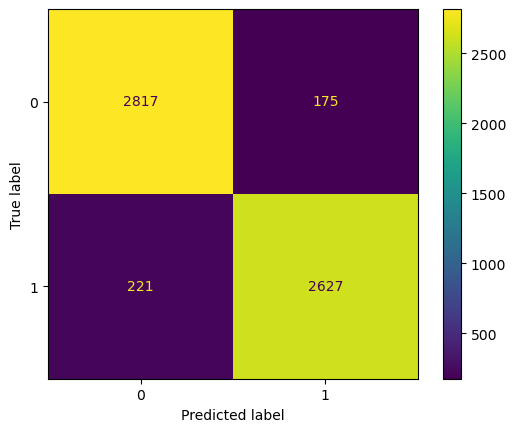

In [310]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Show classification report
best_model = grid.best_estimator_
y_pred = best_model.predict(X_train)
print('Classification Report')
print(classification_report(y_train, y_pred))

# Confusion Matrix
y_pred = best_model.predict(X_train)
confusion = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion)
print('Confusion Matrix')
disp.plot()

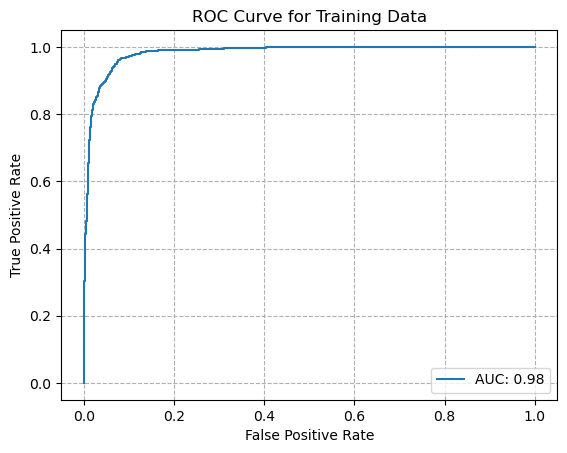

In [311]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Plot ROC curve
y_probs = best_model.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_probs)
auc = roc_auc_score(y_train, y_probs)
plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Training Data')
plt.grid(linestyle='--')
plt.legend()
plt.show()

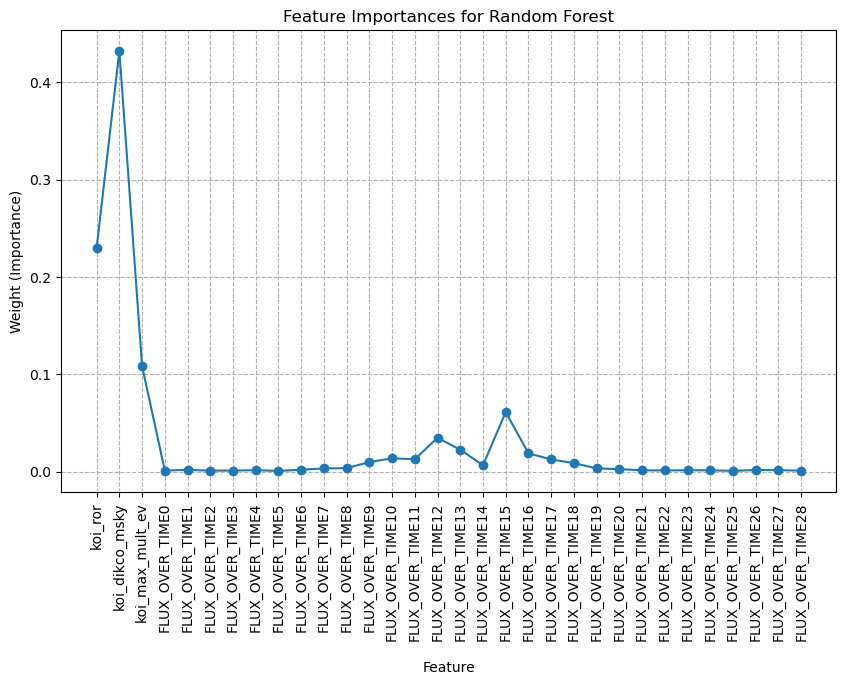

In [312]:
# Show feature importances
plt.figure(figsize=(10,6))
plt.plot(range(len(grid.best_estimator_.feature_importances_)), grid.best_estimator_.feature_importances_, marker='o')
plt.xlabel('Feature', labelpad=15)
plt.ylabel('Weight (Importance)')
plt.xticks(ticks=range(len(X_train.columns)), labels=[X_train.columns[i] for i in range(len(X_train.columns))], rotation=90)
plt.grid(linestyle='--')
plt.title('Feature Importances for Random Forest')
plt.show()

## Model Training: Logistic Regression Classifier

In [313]:
import pandas as pd

# Load data
raw_KOI = pd.read_csv('KOI_cumulative.csv', comment='#')
data = pd.read_csv('transits.csv')
data = data.merge(raw_KOI.reset_index()[['kepoi_name', 'koi_disposition', 'koi_ror', 'koi_dikco_msky', 'koi_max_mult_ev']], on='kepoi_name')
print('Data')
display(data.head())

Data


,kepoi_name,kepid,TIME0,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,...,SAP_QUALITY24,SAP_QUALITY25,SAP_QUALITY26,SAP_QUALITY27,SAP_QUALITY28,SAP_QUALITY29,koi_disposition,koi_ror,koi_dikco_msky,koi_max_mult_ev
0,K00752.01,10797460,170.234933,170.255367,170.275802,170.296236,170.316670,170.337104,170.357538,170.377972,...,393216,393216,393216,393216,393216,262144,CONFIRMED,0.022344,0.32,28.470820
1,K00752.01,10797460,179.736779,179.757213,179.777647,179.798081,179.818515,179.838949,179.859383,179.879817,...,262144,0,16,16,16,16,CONFIRMED,0.022344,0.32,28.470820
2,K00752.01,10797460,189.218149,189.238583,189.259017,189.279450,189.299884,189.320318,189.340752,189.361186,...,0,0,0,0,0,0,CONFIRMED,0.022344,0.32,28.470820
3,K00752.01,10797460,198.699472,198.719906,198.740340,198.760774,198.781208,198.801642,198.822075,198.842509,...,262144,0,0,0,0,0,CONFIRMED,0.022344,0.32,28.470820
4,K00752.02,10797460,162.224762,162.245197,162.265631,162.286065,162.306499,162.326933,162.347367,162.367802,...,16,16,144,16,16,16,CONFIRMED,0.027954,0.50,20.109507


In [ ]:
# Filter to only get time, flux, and the 3 contextual features
cols = data.columns
for col in cols:
    if (col.find('TIME') != -1 and col.find('CORR') == -1) or (col.find('PDCSAP_FLUX') != -1 and col.find('ERR') == -1) or (col.find('koi_disposition') != -1) or (col.find('koi_ror') != -1) or (col.find('koi_dikco_msky') != -1) or (col.find('koi_max_mult_ev') != -1) or (col.find('kepoi_name') != -1) or (col.find('kepid') != -1):
        pass
    else:
        data = data.drop(columns=col)

# Filter to not include candidate class
data = data[data['koi_disposition'] != 'CANDIDATE'].dropna()
print('Data filtered')
display(data.head())

Data filtered


,kepoi_name,kepid,TIME0,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,...,PDCSAP_FLUX24,PDCSAP_FLUX25,PDCSAP_FLUX26,PDCSAP_FLUX27,PDCSAP_FLUX28,PDCSAP_FLUX29,koi_disposition,koi_ror,koi_dikco_msky,koi_max_mult_ev
0,K00752.01,10797460,170.234933,170.255367,170.275802,170.296236,170.316670,170.337104,170.357538,170.377972,...,11491.482,11491.288,11489.856,11491.227,11491.673,11490.764,CONFIRMED,0.022344,0.32,28.470820
1,K00752.01,10797460,179.736779,179.757213,179.777647,179.798081,179.818515,179.838949,179.859383,179.879817,...,11486.404,11488.422,11483.783,11485.129,11491.605,11478.729,CONFIRMED,0.022344,0.32,28.470820
2,K00752.01,10797460,189.218149,189.238583,189.259017,189.279450,189.299884,189.320318,189.340752,189.361186,...,11470.316,11474.607,11491.918,11475.324,11479.686,11478.591,CONFIRMED,0.022344,0.32,28.470820
3,K00752.01,10797460,198.699472,198.719906,198.740340,198.760774,198.781208,198.801642,198.822075,198.842509,...,11481.130,11481.527,11483.515,11476.911,11477.557,11481.815,CONFIRMED,0.022344,0.32,28.470820
4,K00752.02,10797460,162.224762,162.245197,162.265631,162.286065,162.306499,162.326933,162.347367,162.367802,...,11259.315,11261.454,11270.081,11265.063,11254.658,11260.386,CONFIRMED,0.027954,0.50,20.109507


Time and flux measurements will be converted into features that are change in flux over change in time to give the slope of the light curve.

In [ ]:
# Engineer Features
n_times = 30
for i in range(n_times-1):
    change_time = (data[f'TIME{i+1}'] - data[f'TIME{i}'])
    change_flux = (data[f'PDCSAP_FLUX{i+1}'] - data[f'PDCSAP_FLUX{i}'])
    flux_over_time = change_flux / change_time
    data[f'FLUX_OVER_TIME{i}'] = flux_over_time

# Drop time and flux since it's no longer needed
for i in range(n_times):
    data = data.drop(columns=[f'TIME{i}', f'PDCSAP_FLUX{i}'])

In [316]:
print('Engineered Data')
display(data.head())

Engineered Data


,kepoi_name,kepid,koi_disposition,koi_ror,koi_dikco_msky,koi_max_mult_ev,FLUX_OVER_TIME0,FLUX_OVER_TIME1,FLUX_OVER_TIME2,FLUX_OVER_TIME3,...,FLUX_OVER_TIME19,FLUX_OVER_TIME20,FLUX_OVER_TIME21,FLUX_OVER_TIME22,FLUX_OVER_TIME23,FLUX_OVER_TIME24,FLUX_OVER_TIME25,FLUX_OVER_TIME26,FLUX_OVER_TIME27,FLUX_OVER_TIME28
0,K00752.01,10797460,CONFIRMED,0.022344,0.32,28.470820,113.193143,-97.679381,3.083097,-73.699974,...,69.099504,-193.500081,-83.977684,-25.056034,340.166682,-9.493981,-70.078251,67.093731,21.826368,-44.484465
1,K00752.01,10797460,CONFIRMED,0.022344,0.32,28.470820,77.419986,-211.460255,-115.102281,65.576659,...,293.626830,-122.296772,-122.931766,109.865372,-79.769403,98.756490,-227.023588,65.870608,316.921225,-630.126260
2,K00752.01,10797460,CONFIRMED,0.022344,0.32,28.470820,658.409228,37.780540,-239.748653,430.801605,...,-136.488874,131.742505,-127.043163,-233.287658,-233.876059,209.994176,847.166487,-812.077909,213.469839,-53.587421
3,K00752.01,10797460,CONFIRMED,0.022344,0.32,28.470820,116.717807,18.351946,138.202390,93.422727,...,-498.637055,-46.050925,-22.854179,2.251172,27.552389,19.428499,97.289785,-323.190009,31.614286,208.379213
4,K00752.02,10797460,CONFIRMED,0.027954,0.50,20.109507,104.285442,220.709500,45.218310,77.418850,...,309.189052,-341.290581,250.756085,56.963605,-33.424357,104.677453,422.186443,-245.568703,-509.195369,280.314375


The features will be scaled using standard scaler since it will help with convergence.

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, precision_score, accuracy_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Split data into training and testing (80-20)
y = data['koi_disposition'].apply(lambda val: 1 if val == 'CONFIRMED' else 0)
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42, stratify=y)
y_train = data_train['koi_disposition'].apply(lambda val: 1 if val == 'CONFIRMED' else 0)
X_train = data_train.drop(columns=['koi_disposition', 'kepid', 'kepoi_name'])
y_test = data_test['koi_disposition'].apply(lambda val: 1 if val == 'CONFIRMED' else 0)
X_test = data_test.drop(columns=['koi_disposition', 'kepid', 'kepoi_name'])
print('X_train')
display(X_train.head())
print('y_train')
display(y_train.head())

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=scaler.get_feature_names_out())
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=scaler.get_feature_names_out())

# Tune
scoring = {'roc_auc': 'roc_auc',
           'precision': 'precision',
           'accuracy': 'accuracy',
           'recall': 'recall',
           'f1': 'f1'}
params = {'C': [0.1, 1, 5, 10, 15, 20], 'penalty': ['l1', 'l2'], 'max_iter': [100, 200, 500], 'solver': ['lbfgs', 'liblinear', 'saga']}
grid = GridSearchCV(estimator=LogisticRegression(random_state=42), param_grid=params, scoring=scoring, refit='precision', cv=5, n_jobs=-1, verbose=1, return_train_score=True)
grid.fit(X_train, y_train)

# Print best parameters and score
print('Best Parameters:')
print(grid.best_params_)
print()

print('Best Mean Scores Across Splits: Validation')
print('----------------------------')
print(f"Precision: {grid.cv_results_['mean_test_precision'][grid.best_index_]}")
print(f"Recall: {grid.cv_results_['mean_test_recall'][grid.best_index_]}")
print(f"F1: {grid.cv_results_['mean_test_f1'][grid.best_index_]}")
print(f"Accuracy: {grid.cv_results_['mean_test_accuracy'][grid.best_index_]}")
print(f"AUC: {grid.cv_results_['mean_test_roc_auc'][grid.best_index_]}")
print()

print('Best Mean Scores Across Splits: Training')
print('----------------------------')
print(f"Precision: {grid.cv_results_['mean_train_precision'][grid.best_index_]}")
print(f"Recall: {grid.cv_results_['mean_train_recall'][grid.best_index_]}")
print(f"F1: {grid.cv_results_['mean_train_f1'][grid.best_index_]}")
print(f"Accuracy: {grid.cv_results_['mean_train_accuracy'][grid.best_index_]}")
print(f"AUC: {grid.cv_results_['mean_train_roc_auc'][grid.best_index_]}")

# Save model
joblib.dump(grid.best_estimator_, 'logistic_regression.pkl')

X_train


,koi_ror,koi_dikco_msky,koi_max_mult_ev,FLUX_OVER_TIME0,FLUX_OVER_TIME1,FLUX_OVER_TIME2,FLUX_OVER_TIME3,FLUX_OVER_TIME4,FLUX_OVER_TIME5,FLUX_OVER_TIME6,...,FLUX_OVER_TIME19,FLUX_OVER_TIME20,FLUX_OVER_TIME21,FLUX_OVER_TIME22,FLUX_OVER_TIME23,FLUX_OVER_TIME24,FLUX_OVER_TIME25,FLUX_OVER_TIME26,FLUX_OVER_TIME27,FLUX_OVER_TIME28
9248,0.521492,0.123,1227.169600,-412.646210,-1087.638074,-2782.511452,-5354.441345,-6222.347293,-6667.744998,-7447.286253,...,7226.170667,6833.930407,8021.347924,6612.247894,6252.842230,5442.808202,3855.556480,1083.292142,669.112069,-490.268146
5373,0.005223,2.690,14.474333,1375.132130,-428.690975,138.982006,34.745331,-154.152577,-81.724534,-376.819254,...,-324.452883,778.099675,-105.705141,87.596956,-711.548720,714.977831,282.856360,-829.972987,198.684571,-394.436778
9834,0.674816,0.086,44979.660000,-109.624438,-1145.673260,436.540174,-155.138156,-776.183974,496.243913,-73172.713169,...,238892.994348,9852.007008,-279.935204,-73.409222,1868.998796,-1266.070581,-831.971184,1463.283334,224.142825,-447.309049
10241,0.011409,0.400,7.945825,-235.192789,36.556540,-2.740477,-262.401942,396.637027,122.833289,-478.017461,...,-701.174006,908.125514,-176.616538,-415.477897,578.490961,-593.460048,11.696021,156.061896,108.297772,448.021219
4159,0.138957,0.108,1049.078400,-227.023588,-482.086316,-87.550161,593.373789,-375.744466,-1144.030263,-4511.940883,...,4958.109034,5580.481455,3302.372015,1021.185176,-363.317820,281.098752,-258.343937,457.670831,-26.964862,-460.406869


y_train


9248     0
5373     0
9834     0
10241    0
4159     0
Name: koi_disposition, dtype: int64

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters:
{'C': 5, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}

Best Mean Scores Across Splits: Validation
----------------------------
Precision: 0.8759500579521768
Recall: 0.9638405327906762
F1: 0.9177408092497752
Accuracy: 0.9157534246575342
AUC: 0.9532883533104938

Best Mean Scores Across Splits: Training
----------------------------
Precision: 0.878840243747549
Recall: 0.9671699962362001
F1: 0.9208913649905941
Accuracy: 0.9189640410958904
AUC: 0.9585331309709331


['logistic_regression.pkl']

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.87      0.92      2992
           1       0.88      0.97      0.92      2848

    accuracy                           0.92      5840
   macro avg       0.92      0.92      0.92      5840
weighted avg       0.92      0.92      0.92      5840

Confusion Matrix


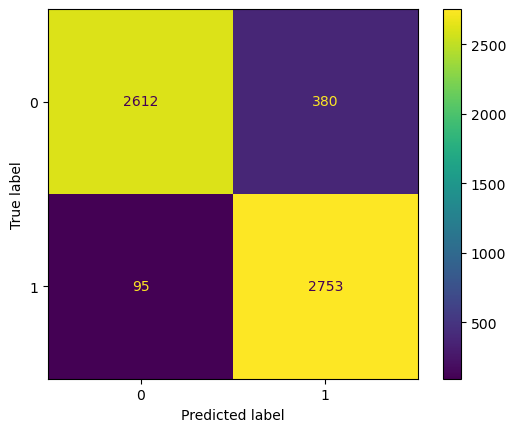

In [318]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Show classification report
best_model = grid.best_estimator_
y_pred = best_model.predict(X_train)
print('Classification Report')
print(classification_report(y_train, y_pred))

# Confusion Matrix
y_pred = best_model.predict(X_train)
confusion = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion)
print('Confusion Matrix')
disp.plot()

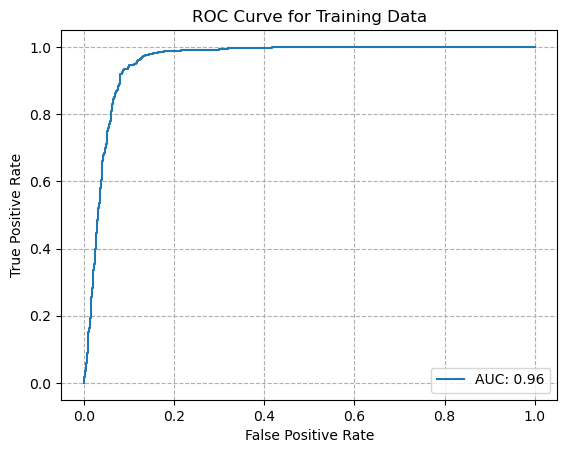

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Plot ROC curve
y_probs = best_model.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_probs)
auc = roc_auc_score(y_train, y_probs)
plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Training Data')
plt.grid(linestyle='--')
plt.legend()
plt.show()

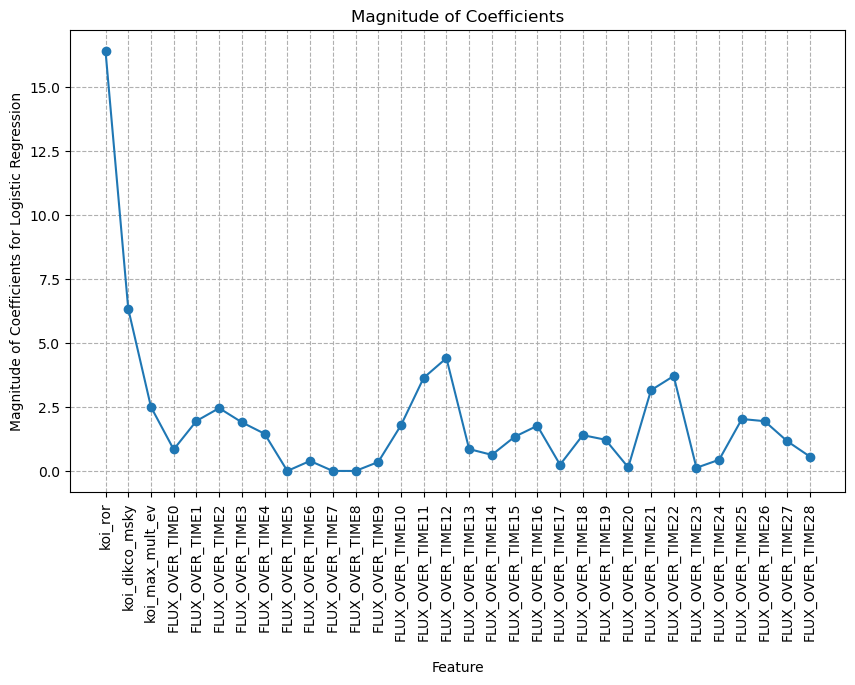

In [ ]:
# Show feature importances
plt.figure(figsize=(10,6))
plt.plot(range(len(grid.best_estimator_.coef_.flatten())), np.abs(grid.best_estimator_.coef_.flatten()), marker='o')
plt.xlabel('Feature', labelpad=15)
plt.ylabel('Magnitude of Coefficients for Logistic Regression')
plt.xticks(ticks=range(len(X_train.columns)), labels=[X_train.columns[i] for i in range(len(X_train.columns))], rotation=90)
plt.grid(linestyle='--')
plt.title('Magnitude of Coefficients')
plt.show()

## Model Training: RNN

In [37]:
import pandas as pd

# Load data
raw_KOI = pd.read_csv('KOI_cumulative.csv', comment='#')
data = pd.read_csv('transits.csv')
data = data.merge(raw_KOI.reset_index()[['kepoi_name', 'koi_disposition', 'koi_ror', 'koi_dikco_msky', 'koi_max_mult_ev']], on='kepoi_name')
print('Data')
display(data.head())

Data


,kepoi_name,kepid,TIME0,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,...,SAP_QUALITY24,SAP_QUALITY25,SAP_QUALITY26,SAP_QUALITY27,SAP_QUALITY28,SAP_QUALITY29,koi_disposition,koi_ror,koi_dikco_msky,koi_max_mult_ev
0,K00752.01,10797460,170.234933,170.255367,170.275802,170.296236,170.316670,170.337104,170.357538,170.377972,...,393216,393216,393216,393216,393216,262144,CONFIRMED,0.022344,0.32,28.470820
1,K00752.01,10797460,179.736779,179.757213,179.777647,179.798081,179.818515,179.838949,179.859383,179.879817,...,262144,0,16,16,16,16,CONFIRMED,0.022344,0.32,28.470820
2,K00752.01,10797460,189.218149,189.238583,189.259017,189.279450,189.299884,189.320318,189.340752,189.361186,...,0,0,0,0,0,0,CONFIRMED,0.022344,0.32,28.470820
3,K00752.01,10797460,198.699472,198.719906,198.740340,198.760774,198.781208,198.801642,198.822075,198.842509,...,262144,0,0,0,0,0,CONFIRMED,0.022344,0.32,28.470820
4,K00752.02,10797460,162.224762,162.245197,162.265631,162.286065,162.306499,162.326933,162.347367,162.367802,...,16,16,144,16,16,16,CONFIRMED,0.027954,0.50,20.109507


In [ ]:
# Filter to only get time, flux, and the 3 contextual features
cols = data.columns
for col in cols:
    if (col.find('TIME') != -1 and col.find('CORR') == -1) or (col.find('PDCSAP_FLUX') != -1 and col.find('ERR') == -1) or (col.find('koi_disposition') != -1) or (col.find('koi_ror') != -1) or (col.find('koi_dikco_msky') != -1) or (col.find('koi_max_mult_ev') != -1) or (col.find('kepoi_name') != -1) or (col.find('kepid') != -1):
        pass
    else:
        data = data.drop(columns=col)

# Filter to not include candidate class
data = data[data['koi_disposition'] != 'CANDIDATE'].dropna()
print('Data filtered')
display(data.head())

Data filtered


,kepoi_name,kepid,TIME0,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,...,PDCSAP_FLUX24,PDCSAP_FLUX25,PDCSAP_FLUX26,PDCSAP_FLUX27,PDCSAP_FLUX28,PDCSAP_FLUX29,koi_disposition,koi_ror,koi_dikco_msky,koi_max_mult_ev
0,K00752.01,10797460,170.234933,170.255367,170.275802,170.296236,170.316670,170.337104,170.357538,170.377972,...,11491.482,11491.288,11489.856,11491.227,11491.673,11490.764,CONFIRMED,0.022344,0.32,28.470820
1,K00752.01,10797460,179.736779,179.757213,179.777647,179.798081,179.818515,179.838949,179.859383,179.879817,...,11486.404,11488.422,11483.783,11485.129,11491.605,11478.729,CONFIRMED,0.022344,0.32,28.470820
2,K00752.01,10797460,189.218149,189.238583,189.259017,189.279450,189.299884,189.320318,189.340752,189.361186,...,11470.316,11474.607,11491.918,11475.324,11479.686,11478.591,CONFIRMED,0.022344,0.32,28.470820
3,K00752.01,10797460,198.699472,198.719906,198.740340,198.760774,198.781208,198.801642,198.822075,198.842509,...,11481.130,11481.527,11483.515,11476.911,11477.557,11481.815,CONFIRMED,0.022344,0.32,28.470820
4,K00752.02,10797460,162.224762,162.245197,162.265631,162.286065,162.306499,162.326933,162.347367,162.367802,...,11259.315,11261.454,11270.081,11265.063,11254.658,11260.386,CONFIRMED,0.027954,0.50,20.109507


The features will be scaled using min-max since it will help with convergence and neural networks often do best with [0,1] range. The model will be hypertuned for precision by using random choices for the number of neurons in a layer, learning rate, etc. This hypertuning will be done with early stopping and 200 epochs; the best model will later be trained across the full 200 epochs without early stopping to further reduce validation loss.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Dropout, BatchNormalization, GRU
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import joblib
import random

# Split data into training and testing (80-20)
y = data['koi_disposition'].apply(lambda val: 1 if val == 'CONFIRMED' else 0)
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42, stratify=y)
y_train = data_train['koi_disposition'].apply(lambda val: 1 if val == 'CONFIRMED' else 0)
X_train = data_train.drop(columns=['koi_disposition', 'kepid', 'kepoi_name'])
y_test = data_test['koi_disposition'].apply(lambda val: 1 if val == 'CONFIRMED' else 0)
X_test = data_test.drop(columns=['koi_disposition', 'kepid', 'kepoi_name'])
print('X_train')
display(X_train.head())
print('y_train')
display(y_train.head())

# Scale
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=scaler.get_feature_names_out())
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=scaler.get_feature_names_out())

# Build model
def build_model(hyperparams, n_timesteps=30, n_time_features=2, n_context_features=3):

    dropout = random.choice(hyperparams['dropout'])
    learning_rate = random.choice(hyperparams['learning_rate'])
    time_layer = random.choice(hyperparams['time_layer'])
    batch_size = random.choice(hyperparams['batch_size'])
    n_neurons_in_order = []

    # Input
    time_input = Input(shape=(n_timesteps, n_time_features), name='time_input')
    context_input = Input(shape=(n_context_features,), name='context_input')

    # RNN
    if time_layer == 'LSTM':
        n_neurons = random.choice(hyperparams['n_neurons'])
        n_neurons_in_order.append(n_neurons)
        time_out = LSTM(n_neurons, return_sequences=True, name='time_1')(time_input)
        time_out = Dropout(dropout, name='time_drop1')(time_out)
        time_out = BatchNormalization(name='time_batch_norm1')(time_out)
        n_neurons = random.choice(hyperparams['n_neurons'])
        n_neurons_in_order.append(n_neurons)
        time_out = LSTM(n_neurons, return_sequences=False, name='time_2')(time_out)
        time_out = Dropout(dropout, name='time_drop2')(time_out)
        time_out = BatchNormalization(name='time_batch_norm2')(time_out)
    elif time_layer == 'GRU':
        n_neurons = random.choice(hyperparams['n_neurons'])
        n_neurons_in_order.append(n_neurons)
        time_out = GRU(n_neurons, return_sequences=True, name='time_1')(time_input)
        time_out = Dropout(dropout, name='time_drop1')(time_out)
        time_out = BatchNormalization(name='time_batch_norm1')(time_out)
        n_neurons = random.choice(hyperparams['n_neurons'])
        n_neurons_in_order.append(n_neurons)
        time_out = GRU(n_neurons, return_sequences=False, name='time_2')(time_out)
        time_out = Dropout(dropout, name='time_drop2')(time_out)
        time_out = BatchNormalization(name='time_batch_norm2')(time_out)
    else:
        print('Unknown option given to "time_layer" hyperparameter! Use "LSTM" and/or "GRU".')
        return None

    # Context
    n_neurons = random.choice(hyperparams['n_neurons'])
    n_neurons_in_order.append(n_neurons)
    context_out = Dense(n_neurons, activation='relu', name='context_out')(context_input)

    # Combined
    combined = Concatenate(name='combined')([time_out, context_out])
    n_neurons = random.choice(hyperparams['n_neurons'])
    n_neurons_in_order.append(n_neurons)
    combined = Dense(n_neurons, activation='relu', name='combined_dense1')(combined)
    combined = Dropout(dropout, name='combined_drop1')(combined)
    combined = BatchNormalization(name='combined_batch_norm1')(combined)
    n_neurons = random.choice(hyperparams['n_neurons'])
    n_neurons_in_order.append(n_neurons)
    combined = Dense(n_neurons, activation='relu', name='combined_dense2')(combined)
    combined = Dropout(dropout, name='combined_drop2')(combined)
    combined = BatchNormalization(name='combined_batch_norm2')(combined)

    # Output
    output = Dense(1, activation='sigmoid', name='output')(combined)
    model = Model(inputs=[time_input, context_input], outputs=output)

    # Return model
    optimizer=Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['precision', 'recall', 'accuracy'])
    return model, {'dropout': dropout, 'learning_rate': learning_rate, 'time_layer': time_layer, 'batch_size': batch_size, 'n_neurons_in_order': n_neurons_in_order}

# Format X_train and y_train into numpy arrays
time_cols = []
flux_cols = []

for col in X_train.columns:
    if (col.find('TIME') != -1):
        time_cols.append(col)
    elif (col.find('PDCSAP_FLUX') != -1):
        flux_cols.append(col)

X_train_time = X_train[time_cols].to_numpy()
X_train_flux = X_train[flux_cols].to_numpy()
X_train_timesteps = np.stack((X_train_time, X_train_flux), axis=-1)
X_train_context = X_train[['koi_ror', 'koi_dikco_msky', 'koi_max_mult_ev']].to_numpy()
y_train = y_train.to_numpy()

# Tune
hyperparams = {'learning_rate': [1e-3, 1e-4, 1e-5], 'n_neurons': [16, 32, 64, 128, 256], 'dropout': [0, 0.1, 0.2, 0.3, 0.4, 0.5], 'time_layer': ['LSTM', 'GRU'], 'batch_size': [16, 32, 64, 128]}
num_fits = 50
precisions = []
models = []

for i in range(num_fits):

    print(f'Fit {i+1} out of {num_fits}')

    model, chosen_params = build_model(hyperparams)

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    model.fit([X_train_timesteps, X_train_context], y_train, epochs=200, batch_size=chosen_params['batch_size'], validation_split=0.2, verbose=1, callbacks=[early_stopping])
    precision = model.history.history['val_precision'][-1]
    precisions.append(precision)
    models.append((model, chosen_params))

# Best model
best_index = precisions.index(max(precisions))
model = models[best_index][0]

# Show best hyperparams
print()
print('Best Hyperparameters')
print(models[best_index][1])

# Save model
joblib.dump(model, 'RNN.pkl')
joblib.dump(model.history, 'RNN_history.pkl')
joblib.dump(models[best_index][1], 'RNN_params.pkl')

X_train


,TIME0,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,...,PDCSAP_FLUX23,PDCSAP_FLUX24,PDCSAP_FLUX25,PDCSAP_FLUX26,PDCSAP_FLUX27,PDCSAP_FLUX28,PDCSAP_FLUX29,koi_ror,koi_dikco_msky,koi_max_mult_ev
9248,340.178838,340.199271,340.219704,340.240137,340.260570,340.281003,340.301436,340.321869,340.342302,340.362734,...,8230.4248,8358.1885,8469.4014,8548.1816,8570.3164,8583.9883,8573.9707,0.521492,0.123,1227.169600
5373,133.085486,133.105920,133.126354,133.146789,133.167223,133.187657,133.208092,133.228526,133.248961,133.269395,...,105895.7000,105881.1600,105895.7700,105901.5500,105884.5900,105888.6500,105880.5900,0.005223,2.690,14.474333
9834,226.856880,226.877314,226.897747,226.918180,226.938614,226.959047,226.979480,226.999914,227.020347,227.040781,...,200424.3400,200462.5300,200436.6600,200419.6600,200449.5600,200454.1400,200445.0000,0.674816,0.086,44979.660000
10241,136.763891,136.784326,136.804760,136.825194,136.845628,136.866063,136.886497,136.906931,136.927366,136.947800,...,10076.3270,10088.1480,10076.0210,10076.2600,10079.4490,10081.6620,10090.8170,0.011409,0.400,7.945825
4159,172.809569,172.830003,172.850437,172.870871,172.891305,172.911739,172.932173,172.952607,172.973041,172.993475,...,25328.0390,25320.6150,25326.3590,25321.0800,25330.4320,25329.8810,25320.4730,0.138957,0.108,1049.078400


y_train


9248     0
5373     0
9834     0
10241    0
4159     0
Name: koi_disposition, dtype: int64

Fit 1 out of 50
Epoch 1/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.4922 - loss: 0.8848 - precision: 0.4947 - recall: 0.4927 - val_accuracy: 0.4812 - val_loss: 0.6945 - val_precision: 0.4802 - val_recall: 0.9982
Epoch 2/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5312 - loss: 0.8216 - precision: 0.5140 - recall: 0.5256 - val_accuracy: 0.4820 - val_loss: 0.7044 - val_precision: 0.4807 - val_recall: 0.9982
Epoch 3/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5304 - loss: 0.8376 - precision: 0.5274 - recall: 0.5255 - val_accuracy: 0.4897 - val_loss: 0.7182 - val_precision: 0.4844 - val_recall: 0.9982
Epoch 4/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5436 - loss: 0.7894 - precision: 0.5272 - recall: 0.5482 - val_accuracy: 0.5000 - val_loss: 0.7097 - val_precision: 0.4895 - val_recall: 0.9964
Epoch 5/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5277 - loss: 0.7920 - precision: 0.5262 - recall: 0.5237 - val_accur

['RNN_history.pkl']

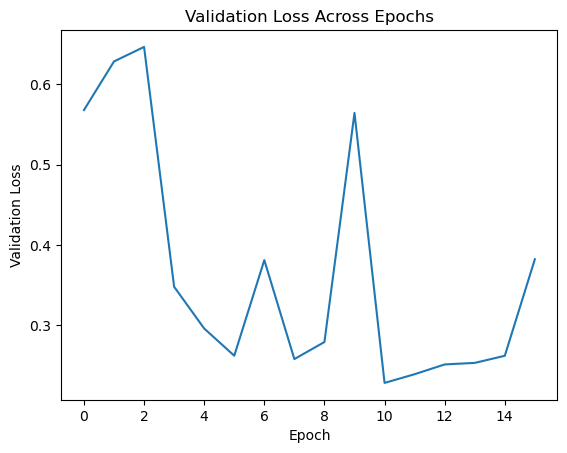

In [ ]:
import matplotlib.pyplot as plt

# Plot validation loss across epochs
plt.plot(range(len(model.history.history['val_loss'])), model.history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Across Epochs')
plt.show()

183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      2992
           1       0.87      0.96      0.91      2848

    accuracy                           0.91      5840
   macro avg       0.92      0.91      0.91      5840
weighted avg       0.92      0.91      0.91      5840

Confusion Matrix


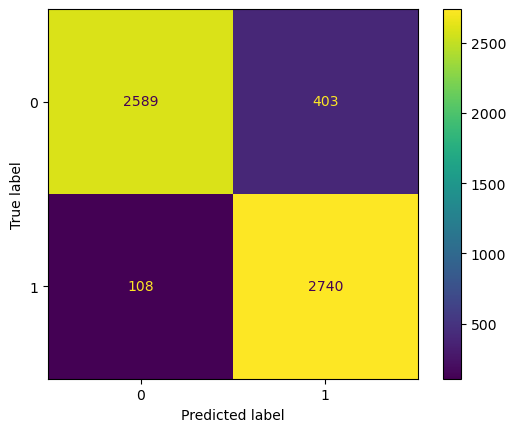

In [274]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Show classification report
best_model = model
y_pred = best_model.predict([X_train_timesteps, X_train_context])
y_pred = (y_pred > 0.5).astype(int)
print('Classification Report')
print(classification_report(y_train, y_pred))

# Confusion Matrix
confusion = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion)
print('Confusion Matrix')
disp.plot()

183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


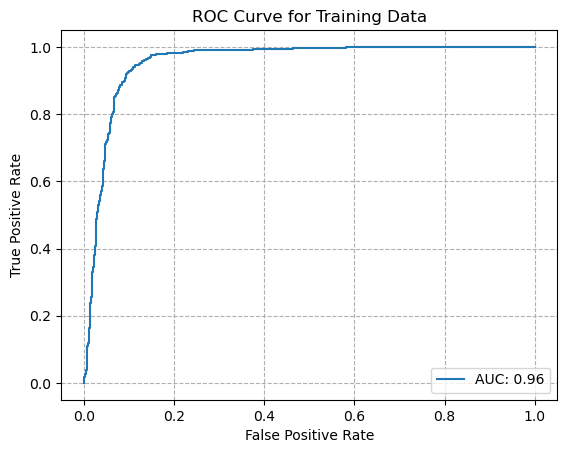

In [275]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Plot ROC curve
y_probs = best_model.predict([X_train_timesteps, X_train_context])
fpr, tpr, thresholds = roc_curve(y_train, y_probs)
auc = roc_auc_score(y_train, y_probs)
plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Training Data')
plt.grid(linestyle='--')
plt.legend()
plt.show()

The validation loss is noisy so the best hypertuned model will be trained for more epochs with a larger batch size.

In [301]:
# Train best model over more epochs

# Build model
def build_final_model(hyperparams, n_timesteps=30, n_time_features=2, n_context_features=3):

    time_layer = hyperparams['time_layer']
    dropout = hyperparams['dropout']
    learning_rate = hyperparams['learning_rate']
    batch_size = hyperparams['batch_size']
    n_neurons_in_order = hyperparams['n_neurons_in_order']
    layer_index = 0

    # Input
    time_input = Input(shape=(n_timesteps, n_time_features), name='time_input')
    context_input = Input(shape=(n_context_features,), name='context_input')

    # RNN
    if time_layer == 'LSTM':
        n_neurons = n_neurons_in_order[layer_index]
        layer_index += 1
        time_out = LSTM(n_neurons, return_sequences=True, name='time_1')(time_input)
        time_out = Dropout(dropout, name='time_drop1')(time_out)
        time_out = BatchNormalization(name='time_batch_norm1')(time_out)
        n_neurons = n_neurons_in_order[layer_index]
        layer_index += 1
        time_out = LSTM(n_neurons, return_sequences=False, name='time_2')(time_out)
        time_out = Dropout(dropout, name='time_drop2')(time_out)
        time_out = BatchNormalization(name='time_batch_norm2')(time_out)
    elif time_layer == 'GRU':
        n_neurons = n_neurons_in_order[layer_index]
        layer_index += 1
        time_out = GRU(n_neurons, return_sequences=True, name='time_1')(time_input)
        time_out = Dropout(dropout, name='time_drop1')(time_out)
        time_out = BatchNormalization(name='time_batch_norm1')(time_out)
        n_neurons = n_neurons_in_order[layer_index]
        layer_index += 1
        time_out = GRU(n_neurons, return_sequences=False, name='time_2')(time_out)
        time_out = Dropout(dropout, name='time_drop2')(time_out)
        time_out = BatchNormalization(name='time_batch_norm2')(time_out)
    else:
        print('Unknown option given to "time_layer" hyperparameter! Use "LSTM" and/or "GRU".')
        return None

    # Context
    n_neurons = n_neurons_in_order[layer_index]
    layer_index += 1
    context_out = Dense(n_neurons, activation='relu', name='context_out')(context_input)

    # Combined
    combined = Concatenate(name='combined')([time_out, context_out])
    n_neurons = n_neurons_in_order[layer_index]
    layer_index += 1
    combined = Dense(n_neurons, activation='relu', name='combined_dense1')(combined)
    combined = Dropout(dropout, name='combined_drop1')(combined)
    combined = BatchNormalization(name='combined_batch_norm1')(combined)
    n_neurons = n_neurons_in_order[layer_index]
    layer_index += 1
    combined = Dense(n_neurons, activation='relu', name='combined_dense2')(combined)
    combined = Dropout(dropout, name='combined_drop2')(combined)
    combined = BatchNormalization(name='combined_batch_norm2')(combined)

    # Output
    output = Dense(1, activation='sigmoid', name='output')(combined)
    model = Model(inputs=[time_input, context_input], outputs=output)

    # Return model
    optimizer=Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['precision', 'recall', 'accuracy'])
    return model, {'dropout': dropout, 'learning_rate': learning_rate, 'time_layer': time_layer, 'batch_size': batch_size, 'n_neurons_in_order': n_neurons_in_order}

# Tune
hyperparams = {
    'dropout': 0.1,
    'learning_rate': 0.0001,
    'time_layer': 'LSTM',
    'batch_size': 32,
    'n_neurons_in_order': [256, 128, 64, 128, 16]
    }
model, chosen_params = build_final_model(hyperparams)
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
model.fit([X_train_timesteps, X_train_context], y_train, epochs=200, batch_size=chosen_params['batch_size'], validation_split=0.2, verbose=1)

print(f'Final Hyperparameters: {chosen_params}')

# Save model
joblib.dump(model, 'RNN.pkl')
joblib.dump(model.history, 'RNN_history.pkl')
joblib.dump(chosen_params, 'RNN_params.pkl')

Epoch 1/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.5537 - loss: 0.8058 - precision: 0.5611 - recall: 0.4543 - val_accuracy: 0.5205 - val_loss: 0.6865 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.5882 - loss: 0.7159 - precision: 0.6123 - recall: 0.4980 - val_accuracy: 0.6943 - val_loss: 0.6720 - val_precision: 0.7034 - val_recall: 0.6268
Epoch 3/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6074 - loss: 0.6925 - precision: 0.6184 - recall: 0.5366 - val_accuracy: 0.6866 - val_loss: 0.6485 - val_precision: 0.7425 - val_recall: 0.5304
Epoch 4/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6321 - loss: 0.6695 - precision: 0.6377 - recall: 0.5711 - val_accuracy: 0.7132 - val_loss: 0.6328 - val_precision: 0.7095 - val_recall: 0.6804
Epoch 5/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6235 - loss: 0.6808 - precision: 0.6271 - recall: 0.5727 - val_accuracy: 0.7

['RNN_params.pkl']

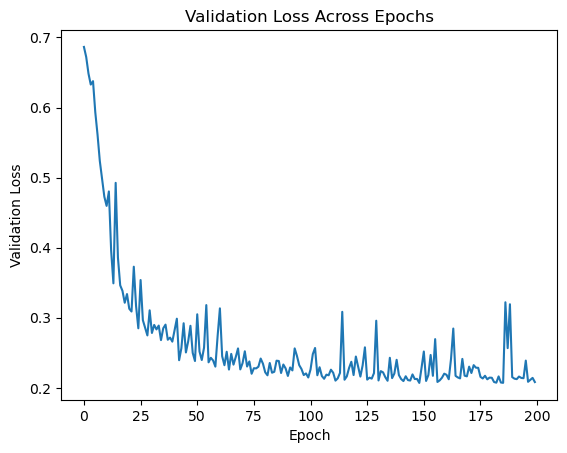

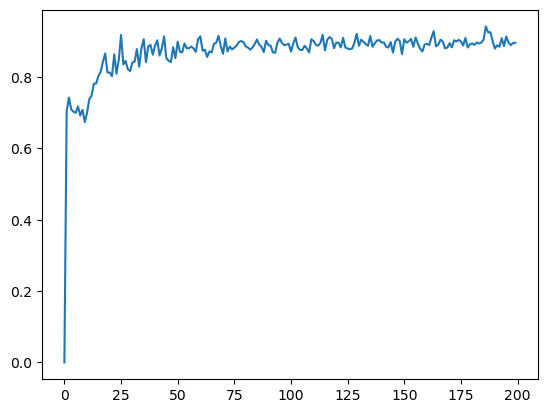

In [ ]:
import matplotlib.pyplot as plt

# Plot validation loss across epochs
plt.plot(range(len(joblib.load('RNN_history.pkl').history['val_loss'])), joblib.load('RNN_history.pkl').history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Across Epochs')
plt.show()

# Plot validation precision across epochs
plt.plot(range(len(joblib.load('RNN_history.pkl').history['val_precision'])), joblib.load('RNN_history.pkl').history['val_precision'])
plt.show()

183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      2992
           1       0.90      0.95      0.92      2848

    accuracy                           0.92      5840
   macro avg       0.92      0.92      0.92      5840
weighted avg       0.92      0.92      0.92      5840

Confusion Matrix


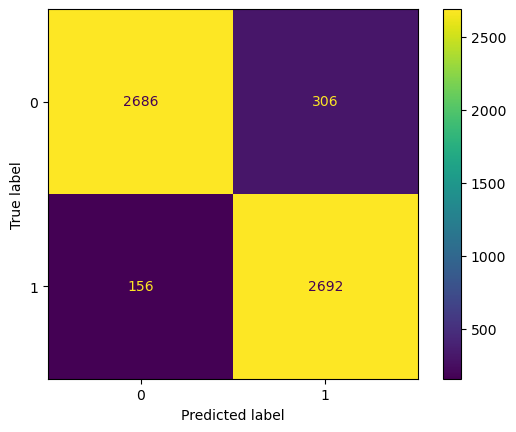

In [303]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Show classification report
best_model = model
y_pred = best_model.predict([X_train_timesteps, X_train_context])
y_pred = (y_pred > 0.5).astype(int)
print('Classification Report')
print(classification_report(y_train, y_pred))

# Confusion Matrix
confusion = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion)
print('Confusion Matrix')
disp.plot()

183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


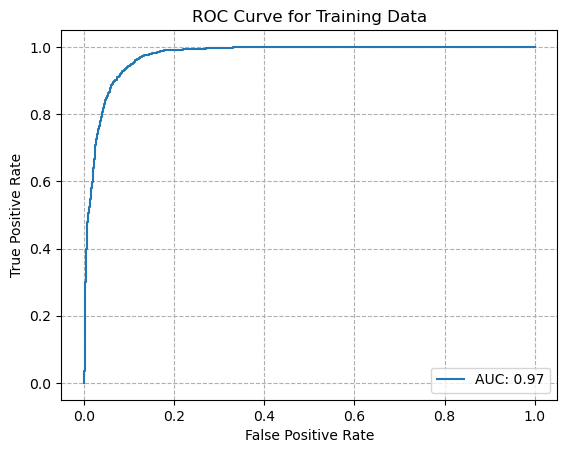

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Plot ROC curve
y_probs = best_model.predict([X_train_timesteps, X_train_context])
fpr, tpr, thresholds = roc_curve(y_train, y_probs)
auc = roc_auc_score(y_train, y_probs)
plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Training Data')
plt.grid(linestyle='--')
plt.legend()
plt.show()

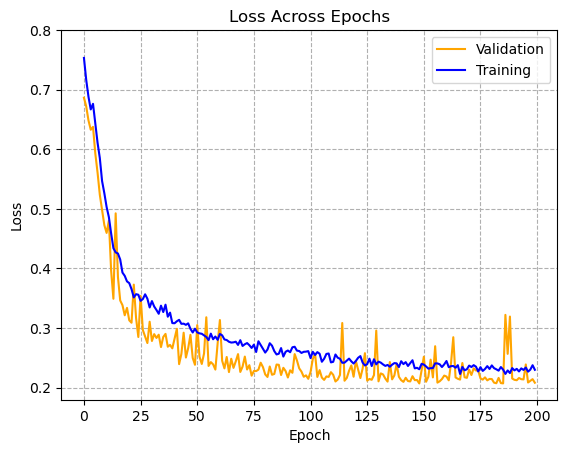

In [9]:
import joblib
import matplotlib.pyplot as plt
import numpy as np

# Plot both validation and training loss across epochs
val_loss = joblib.load('RNN_history.pkl').history['val_loss']
train_loss = joblib.load('RNN_history.pkl').history['loss']
epochs = range(len(val_loss))

plt.plot(epochs, val_loss, color='orange', label='Validation')
plt.plot(epochs, train_loss, color='blue', label='Training')
plt.title('Loss Across Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.yticks(ticks=np.arange(0.2, 0.9, 0.1))
plt.grid(linestyle='--')
plt.legend()
plt.show()